# Realtime Results Analysis
Created by Kevin Ta 2021.03.23

In [1]:
# Import relevant modules
import os
import time
from datetime import datetime
from scipy import signal

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
# define parameters for retrieving files
WIN_SIZE = 16
INTENTIONS_DICT = [
    ('Mahsa', 'Obstacles15', 'T3'),
    ('Mahsa', 'Obstacles35', 'T3'),
    ('Mahsa', 'RampA', 'T3'),
    ('Mahsa', 'StraightF', 'T3'),
    ('Mahsa', 'Turn90FL', 'T3'),
    ('Mahsa', 'Turn90FR', 'T3'),
    ('Mahsa', 'Turn180L', 'T3'),
    ('Mahsa', 'Turn180R', 'T3'),
]
DICT_NUM = 4

# set the current directory
current_path = os.getcwd()

# read the data
data = pd.read_csv(os.path.join(current_path, '2021-Results', '200ms-{}-{}-{}.csv'.format(WIN_SIZE, INTENTIONS_DICT[DICT_NUM][1], INTENTIONS_DICT[DICT_NUM][0])))

In [3]:
# Pipeline Inspection
#pipeline = joblib.load(os.path.join(current_path, 'models', 'model.joblib'))
#print(pipeline.steps)
#print(pipeline['cluster'].covariances_.max())
#print(pipeline['cluster'].covariances_.min())
#print(pipeline['cluster'].covariances_.mean())
#print(pipeline['cluster'].covariances_.std())

(1616883511.8472705, 1616883537.1168818)

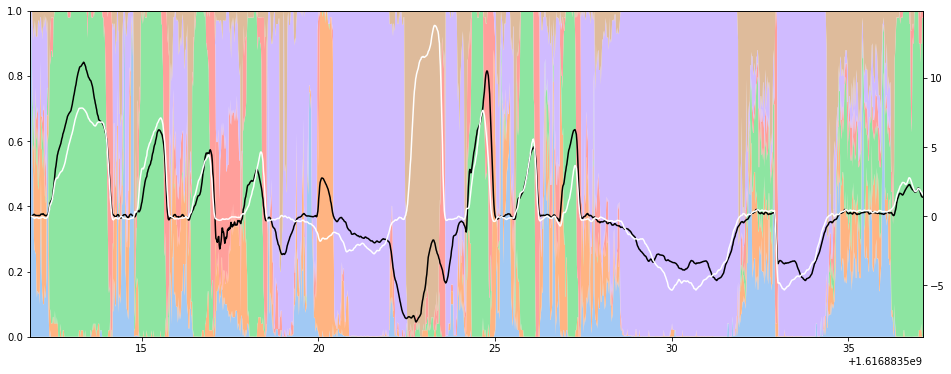

In [4]:
# extract cluster probabilities and torque values
clusters = data[['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']]
torques = data[['Torque L', 'Torque R']]

# set colourmap for stackplot
col = sns.color_palette('pastel')

# plot stackplot of probabilities
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.stackplot(data['Time'].values, clusters.T, colors=col)

ax2 = ax1.twinx()

# plot torque values
ax2.plot(data['Time'], torques['Torque L'], 'k', data['Time'], torques['Torque R'], 'w')

ax1.set_ylim((0, 1))
ax1.set_xlim((data['Time'].min(), data['Time'].max()))

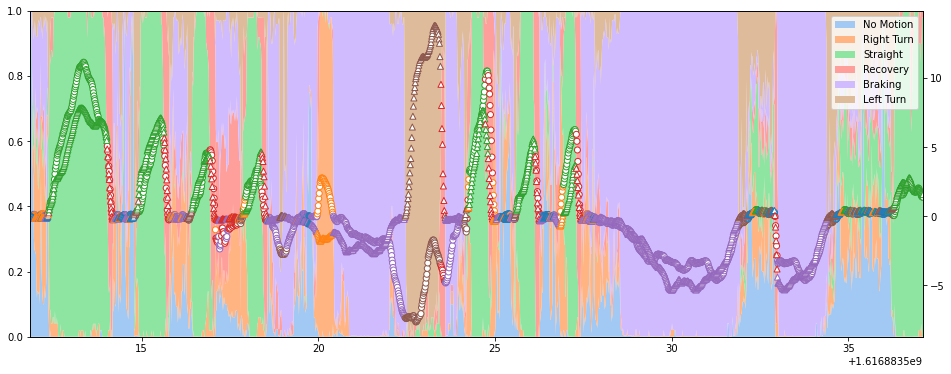

In [18]:
# map clusters for colours
cluster_dict = {'Cluster 1': 0, 'Cluster 2':1, 'Cluster 3':2, 'Cluster 4':3, 'Cluster 5':4, 'Cluster 6':5}

# set colourmaps for probabilities and classification
colstack = sns.color_palette('pastel')
col = sns.color_palette('tab10')

# get the classification
cluster_idx = clusters.T.idxmax()

# reformat into np array
cluster_i = [cluster_dict[idx] for idx in cluster_idx.values]

# reformat into list of colors
cols = [col[i] for i in cluster_i]

# plot
fig, ax1 = plt.subplots(figsize=(16,6))

# plot probabilities stackplot
ax1.stackplot(data['Time'].values, clusters.T, colors=colstack)

ax2 = ax1.twinx()

# plot torques with appropriate colour mapping
ax2.scatter(data['Time'], torques['Torque L'], marker = 'o', facecolor = 'w', color=cols)
ax2.scatter(data['Time'], torques['Torque R'], marker = '^', facecolor = 'w', color=cols)

ax1.set_ylim((0, 1))
ax1.set_xlim((data['Time'].min(), data['Time'].max()))

# legend
ax1.legend(['No Motion', 'Right Turn', 'Straight', 'Recovery', 'Braking', 'Left Turn'])

In [6]:
# examine classification run time speed
for trial in INTENTIONS_DICT:

    dataT = pd.read_csv(os.path.join(current_path, '2021-Results', '200ms-{}-{}-{}.csv'.format(WIN_SIZE, trial[1], trial[0])))
    
    timeDiffs_temp = np.diff(dataT['Time'].to_numpy())
    print(timeDiffs_temp.mean())
    print(timeDiffs_temp.std())

0.013718480956434284
0.0018656641690228033
0.013651658539938006
0.0015521904454402866
0.013652593456708075
0.0014894900353314136
0.013550775599591608
0.0014276665555295078
0.013696266319047468
0.0014389182038519936
0.013584103674258826
0.001494953679767986
0.013685788938907978
0.001503421276441462
0.01367910473774641
0.0014331179728983023


# Bayesian Tracking

In [16]:
# columns are transitions from cluster i to cluster j, columns add up to 1
# process model parameters
p = 0.9
pt = (1 - p) / 5
# measurement model parameters
m = 0.9
mt = (1 - m) / 5
process_model = np.array([[p,  pt, pt, pt, pt, pt],
                          [pt, p,  pt, pt, pt, pt],
                          [pt, pt, p,  pt, pt, pt],
                          [pt, pt, pt, p,  pt, pt],
                          [pt, pt, pt, pt, p,  pt],
                          [pt, pt, pt, pt, pt, p]])
measure_model = np.array([[m,  mt, mt, mt, mt, mt],
                          [mt, m,  mt, mt, mt, mt],
                          [mt, mt, m,  mt, mt, mt],
                          [mt, mt, mt, m,  mt, mt],
                          [mt, mt, mt, mt, m,  mt],
                          [mt, mt, mt, mt, mt, m]])

# prior update and measurement update arrays
p_xc_zp = np.ones(6)/6
p_xc_zc = np.ones(6)/6

# filtered clusters
clusters_bayesian = np.array([p_xc_zc])

# perform updates
for cluster_model in clusters.values:
    p_xc_zp = process_model @ p_xc_zc
    measurement_model = np.multiply(measure_model, np.repeat(cluster_model.reshape(-1,1), axis=1, repeats=6))
    measurement_model = np.divide(measurement_model, measurement_model.sum(axis=0))
    p_xc_zc =  measurement_model @ p_xc_zp
    clusters_bayesian = np.append(clusters_bayesian, p_xc_zc.reshape(1,-1), axis=0)

# remove initial uniform result
clusters_bayesian=clusters_bayesian[1::]

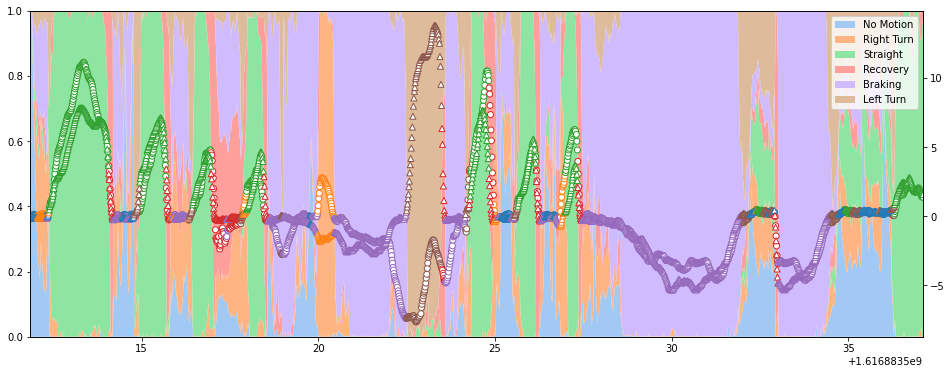

In [17]:
# get cluster index
cluster_idx = clusters_bayesian.T.argmax(axis=0)

# get colourmapping list
cols = [col[i] for i in cluster_idx]

# plot
fig2, ax1 = plt.subplots(figsize=(16,6))

# stackplot of probabilities
ax1.stackplot(data['Time'].values, clusters_bayesian.T, colors=colstack)

ax2 = ax1.twinx()

# plot torques with classification
ax2.scatter(data['Time'], torques['Torque L'], marker = 'o', facecolor = 'w', color=cols)
ax2.scatter(data['Time'], torques['Torque R'], marker = '^', facecolor = 'w', color=cols)

ax1.set_ylim((0, 1))
ax1.set_xlim((data['Time'].min(), data['Time'].max()))

# legend
ax1.legend(['No Motion', 'Right Turn', 'Straight', 'Recovery', 'Braking', 'Left Turn'])